In [1]:
from __future__ import print_function
import binascii
import struct
from PIL import Image, ImageStat
import numpy as np
import scipy
import scipy.misc
import scipy.cluster
import os
import tempfile
from google.cloud import storage
from google.cloud.storage import Blob
import io
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import math
from google.cloud import bigquery

In [8]:
!pip freeze

alabaster==0.7.11
alembic==1.2.0
anaconda-client==1.7.2
anaconda-navigator==1.9.2
anaconda-project==0.8.2
appdirs==1.4.3
asn1crypto==1.2.0
astroid==2.0.4
astropy==3.0.4
async-generator==1.10
atomicwrites==1.2.1
attrs==18.2.0
Automat==0.7.0
Babel==2.6.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.3
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==2.1.4
blinker==1.4
bokeh==0.13.0
boto==2.49.0
Bottleneck==1.2.1
cachetools==3.1.1
certifi==2019.9.11
certipy==0.1.3
cffi==1.13.1
chardet==3.0.4
click==6.7
cloudpickle==0.5.5
clyent==1.2.2
colorama==0.3.9
conda==4.5.11
conda-build==3.15.1
constantly==15.1.0
contextlib2==0.5.5
cryptography==2.8
cycler==0.10.0
Cython==0.28.5
cytoolz==0.9.0.1
dask==0.19.1
datashape==0.5.4
decorator==4.4.1
defusedxml==0.5.0
distributed==1.23.1
docutils==0.14
entrypoints==0.3
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==3.0.8
findspark==1.3.0
Flask==1.0.2
Flask-Cors==3.0.6
gevent==1.3.6
glob2==0.6
gmpy2==2.0.8
google-api-core==1.1

In [2]:
def show_color(colors):
    fig,ax = plt.subplots()
    currentAxis = plt.gca()
    x=0
    y=0
    width = 1/len(colors)
    for rgb in colors:
        colour = binascii.hexlify(bytearray(int(c) for c in rgb)).decode('ascii')
        colour = '#'+colour
        currentAxis.add_patch(Rectangle((x, y), width, 1, alpha=1, facecolor=colour))
        x=x+width

def dominant_colors(ar):
    NUM_CLUSTERS = 5
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
#     print('cluster centres:\n', codes)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences
#     print(counts)
    index_max = scipy.argmax(counts)                    # find most frequent
    peak = codes[index_max]
#     print(peak)
#     print('cluster centres:\n', codes)
    return codes , peak

def image_colorfulness(image):
    # split the image into its respective RGB components
#     (B, G, R) = cv2.split(image.astype("float"))
    R = np.array([x[0] for x in image])
    G = np.array([x[1] for x in image])
    B = np.array([x[2] for x in image])
    # compute rg = R - G
    rg = np.absolute(R - G)
 
    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)
 
    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
 
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
 
    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)

def image_brightness(im):
   stat = ImageStat.Stat(im)
   r,g,b = stat.mean
   return math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))

def insert_into_bigquery(rows):
    # Instantiates a client
    bigquery_client = bigquery.Client()

    # Prepares a reference to the dataset
    dataset_ref = bigquery_client.dataset('book_cover_data')

    table_ref = dataset_ref.table('image_data')
    table = bigquery_client.get_table(table_ref)  # API call

    errors = bigquery_client.insert_rows(table, rows)  # API request
    assert errors == []

In [3]:
process_all_files = True

file_name = 'covers/224x224/0021355681.jpg'
bucket_name = 'book-covers-e6893'

client = storage.Client()
bucket = client.get_bucket('book-covers-e6893')
if process_all_files:    
    blobs = list(bucket.list_blobs(prefix='covers/224x224/'))
    print(blobs)
else:
    blobs = [Blob(file_name, bucket)]
cnt=0
print(len(blobs))
rows=[]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
cnt < len(blobs)

True

In [ ]:
cnt=39900
while cnt < len(blobs):
    blob = blobs[cnt]
    file_number = blob.name.split('/')[-1][:-4]
#     print(file_number)
    cnt+=1
    if cnt % 50 == 0:
        print("Processing File "+str(cnt)+" of "+str(len(blobs))+'\n')
    contenido = blob.download_as_string()
    
    fp = io.BytesIO(contenido)
    im = Image.open(fp)
    ar = np.asarray(im)
    # print(ar)
    shape = ar.shape
    # print(shape)
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

    colorfullness = image_colorfulness(ar)
    bright = image_brightness(im)
    codes, peak = dominant_colors(ar)
    
    if not process_all_files:
        print('Colorfullness')
        print(round(colorfullness,2))

        print('\n\nBrightness')
        print(round(bright,2))

        print('\n\nTop 5 Colors')
        show_color(codes)
        
    rows.append((file_number,round(peak[0],2),round(peak[2],2),round(peak[2],2),round(bright,2),round(colorfullness,2)))
    if cnt % 5000 == 0:
        insert_into_bigquery(rows)
        rows = []
#     print(rows)
    
insert_into_bigquery(rows)

Processing File 39950 of 57000

Processing File 40000 of 57000

Processing File 40050 of 57000

Processing File 40100 of 57000

Processing File 40150 of 57000

Processing File 40200 of 57000

Processing File 40250 of 57000

Processing File 40300 of 57000

Processing File 40350 of 57000

Processing File 40400 of 57000

Processing File 40450 of 57000

Processing File 40500 of 57000

Processing File 40550 of 57000

Processing File 40600 of 57000

Processing File 40650 of 57000

Processing File 40700 of 57000

Processing File 40750 of 57000

Processing File 40800 of 57000

Processing File 40850 of 57000

Processing File 40900 of 57000

Processing File 40950 of 57000

Processing File 41000 of 57000

Processing File 41050 of 57000

Processing File 41100 of 57000

Processing File 41150 of 57000

Processing File 41200 of 57000

Processing File 41250 of 57000

Processing File 41300 of 57000

Processing File 41350 of 57000

Processing File 41400 of 57000

Processing File 41450 of 57000

Processi

0001484524
My program took 0.038672447204589844 to download
My program took 0.0014727115631103516 to run
My program took 0.06541013717651367 to image_colorfulness
My program took 0.00039196014404296875 to image_brightness
My program took 0.5668056011199951 to dominant_colors
Colorfullness
68.34


Brightness
188.16


Top 5 Colors
[[214.73101611 171.89875257 162.07920552]
 [128.7524344  128.59976894 112.947186  ]
 [209.95565263  81.13674874  76.36523696]
 [ 72.69454641  50.9934452   62.05374934]
 [249.33459905 248.53376613 245.05111873]]
0001956604
My program took 0.04008936882019043 to download
My program took 0.0013914108276367188 to run
My program took 0.06136298179626465 to image_colorfulness
My program took 0.0005719661712646484 to image_brightness
My program took 0.6240153312683105 to dominant_colors
Colorfullness
33.15


Brightness
145.68


Top 5 Colors
[[194.1677744  185.45145661 175.55400957]
 [100.00979624  68.2065047   40.57582288]
 [130.79223769  95.43295691  56.15831597]
 [1

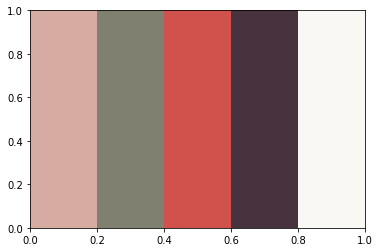

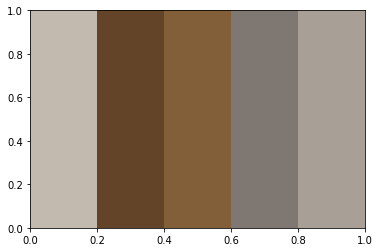

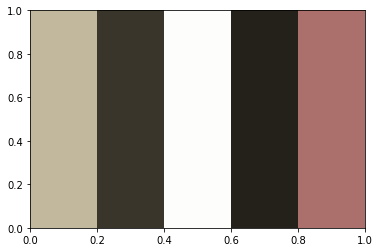

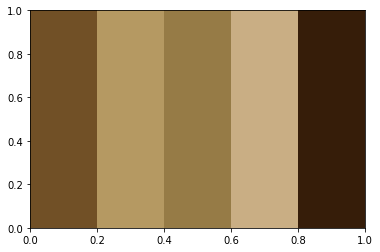

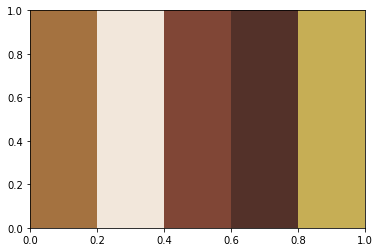

In [24]:
import time
cnt=0
for blob in blobs:
    start_time = time.time()
    file_number = blob.name.split('/')[-1][:-4]
    print(file_number)
    cnt+=1
    if cnt > 5:
        break
        
    contenido = blob.download_as_string()
    start_time = time.time()
    fp = io.BytesIO(contenido)
    im = Image.open(fp)
    ar = np.asarray(im)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    
    colorfullness = image_colorfulness(ar)
    start_time = time.time()
    bright = image_brightness(im)
    start_time = time.time()
    codes, peak = dominant_colors(ar)
    

In [ ]:
insert_into_bigquery(rows)